In [1]:
import re
import os
import mat73
import scipy.io as sio
import numpy as np
from scipy.optimize import curve_fit
import itertools
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Change the following line for a new case
data_address = 'C://Users//Gundogdu//Desktop//University of Chicago//PATIENT_DATA//IRB17//pat083//master.mat'
data_address2 = 'C://Users//Gundogdu//Desktop//University of Chicago//PATIENT_DATA//IRB17//pat083//master3.mat'

In [3]:
print('Loading data')
try:
    data = sio.loadmat(data_address)
except NotImplementedError:
    data = mat73.loadmat(data_address)
print('Data loaded')
print('Loading data')
try:
    data2 = sio.loadmat(data_address2)
except NotImplementedError:
    data2 = mat73.loadmat(data_address2)
print('Data loaded')

Loading data


ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: images.roi.Freehand, (uint32)


Data loaded
Loading data
Data loaded


In [12]:

b_values = data['b']
TE_values = data['TE']
TE_norm = data['TE_norm']
hybrid_data = data['hybrid_data']
hybrid_raw = data['hybrid_raw']
registered_hybrid= data2['registered_hybrid']
hybrid_raw_reshaped = hybrid_data.copy()
for b in range(4):
    for te in range(4):
        hybrid_raw_reshaped[:, :, :, b, te] = np.mean(hybrid_raw[b][te], -1) if b else hybrid_raw[b][te]

In [12]:
def three_compartment_fit(M, D_ep, D_lu, D_st, T2_ep, T2_lu, T2_st, V_ep, V_st):
    """
    
    Three-compartment fit for Hybrid estimation
    
    """
    b, TE = M
    S_ep = V_ep*np.exp(-b/1000*D_ep)*np.exp(-TE/T2_ep)
    S_st = V_st*np.exp(-b/1000*D_st)*np.exp(-TE/T2_st)
    S_lu =(1 - V_ep - V_st)*np.exp(-b/1000*D_lu)*np.exp(-TE/T2_lu)
    
    return S_ep + S_st + S_lu


In [14]:
def three_compartment_fit3(M,  V_ep, V_st, p = [0.55, 2.8, 1.3, 50, 750, 70] ):
    """
    
    Three-compartment fit for Hybrid estimation
    
    """
    D_ep, D_lu, D_st, T2_ep, T2_lu, T2_st = p
    b, TE = M
    S_ep = V_ep*np.exp(-b/1000*D_ep)*np.exp(-TE/T2_ep)
    S_st = V_st*np.exp(-b/1000*D_st)*np.exp(-TE/T2_st)
    S_lu = (1 - V_ep - V_lu)*np.exp(-b/1000*D_lu)*np.exp(-TE/T2_lu)
    
    return S_ep + S_st + S_lu

In [15]:
def hybrid_slice_fit(normTE, b, slicedata):
    eps = 1e-7;
    numrows, numcols, numbvalues, numTEvalues = slicedata.shape
    fitcoeffs = np.zeros((numrows, numcols, 9))
    for row in tqdm(range(numrows)):
        for col in range(numcols):
            voxel_cancer = np.squeeze(slicedata[row, col, :, :]/(slicedata[row, col, 0, 0] + eps))
            TE_norm = normTE
            bvals = b
            X, Y = np.meshgrid(bvals, TE_norm)
            xdata = np.vstack((X.ravel(), Y.ravel()))
            ydata = voxel_cancer.T.ravel()
            xdata = xdata[:, ~np.isnan(ydata)]
            ydata = ydata[~np.isnan(ydata)]
            try:
                fitdata_, _  = curve_fit(three_compartment_fit3, 
                                           xdata,
                                           ydata,
                                           p0 = [0.55, 2.8, 1.3, 50, 750, 70, 0.3, 0.4],
                                           check_finite=True,
                                           #sigma = 1/(ydata + eps),
                                           #absolute_sigma = True,
                                           bounds=([0.3, 2.7, 0.7, 20, 500, 40, 0, 0],
                                                   [0.7, 3.0, 1.7, 70, 1000, 100, 1, 1]),
                                          method='trf',
                                          maxfev=5000)
            except RuntimeError:
                fitdata_ = [0.55, 2.8, 1.3, 50, 750, 70, 0.3, 0.4]
            coeffs = fitdata_
            fitcoeffs[row, col, 0:6] = [0.55, 2.8, 1.3, 50, 750, 70]
            fitcoeffs[row, col, 0:8] = coeffs
            fitcoeffs[row, col, 8] = 1 - coeffs[0] - coeffs[1]
            #fitcoeffs[row, col, 8] = 1 - coeffs[6] - coeffs[7]
    return fitcoeffs

In [11]:
import numpy as np
D_ep_ = [0.3, 0.55, 0.7]
D_st_ = [0.7, 1.3, 1.7]
T2_ep_ = [20, 50, 70]
T2_st_ = [40, 70, 100]
TE = 100
b = 1500

for D_ep in D_ep_:
    for T2_ep in T2_ep_:
        print(np.exp(-b/1000*D_ep)*np.exp(-TE/T2_ep))
print('halt')
for D_st in D_st_:
    for T2_st in T2_st_:        
        print(np.exp(-b/1000*D_st)*np.exp(-TE/T2_st))

0.004296304690752341
0.08629358649937052
0.15280824740061175
0.0029528041523734466
0.05930865682943873
0.10502347014927887
0.002357862006490233
0.047358924391140936
0.08386294426459051
halt
0.028724639654239437
0.08386294426459051
0.12873490358780426
0.011678566970395442
0.03409612871449937
0.05233970594843238
0.006409333446256384
0.018712352184276925
0.028724639654239437


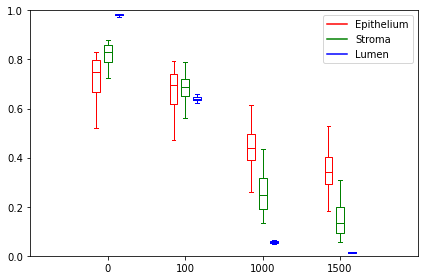

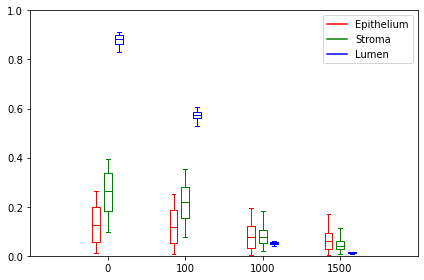

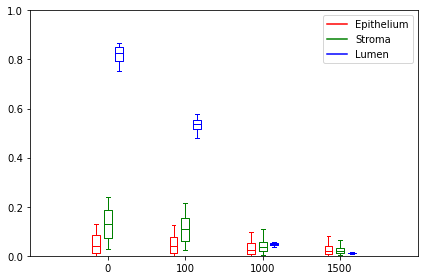

In [7]:
import matplotlib.pyplot as plt
import numpy as np

D_ep_ = np.linspace(0.3, 0.7, 50)
D_st_ = np.linspace(0.7, 1.7, 50)
D_lu_ = np.linspace(2.7, 3, 50)
T2_ep_ = np.linspace(20, 70, 50)
T2_st_ = np.linspace(40, 100,50)
T2_lu_ = np.linspace(500, 1000, 50)



for TE in (13, 93, 143):   
    ep = []
    st = []
    lu = []
    for b in (0, 150, 1000, 1500):
        s_ep = []
        s_st = []
        s_lu = []
        for D in D_ep_:
            for T2 in T2_ep_:
                s_ep.append(np.exp(-b/1000*D)*np.exp(-TE/T2))
        ep.append(s_ep)
        for D in D_st_:
            for T2 in T2_st_:
                s_st.append(np.exp(-b/1000*D)*np.exp(-TE/T2))
        st.append(s_st)
        for D in D_lu_:
            for T2 in T2_lu_:
                s_lu.append(np.exp(-b/1000*D)*np.exp(-TE/T2))
        lu.append(s_lu)



    ticks = ['0', '100', '1000', '1500']

    def set_box_color(bp, color):
        plt.setp(bp['boxes'], color=color)
        plt.setp(bp['whiskers'], color=color)
        plt.setp(bp['caps'], color=color)
        plt.setp(bp['medians'], color=color)

    plt.figure()

    bpep = plt.boxplot(ep, positions=np.array(range(4))*2.0-0.3, sym='', widths=0.2)
    bst = plt.boxplot(st, positions=np.array(range(4))*2.0, sym='', widths=0.2)
    blu = plt.boxplot(lu, positions=np.array(range(4))*2.0+0.3, sym='', widths=0.2)
    set_box_color(bpep, 'red') # colors are from http://colorbrewer2.org/
    set_box_color(bst, 'green')
    set_box_color(blu, 'blue')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='red', label='Epithelium')
    plt.plot([], c='green', label='Stroma')
    plt.plot([], c='blue', label='Lumen')
    plt.legend()

    plt.xticks(range(0, len(ticks) * 2, 2), ticks)
    plt.xlim(-2, len(ticks)*2)
    plt.ylim(0, 1.)
    plt.tight_layout()

In [17]:
def hybrid_slice_fit2(normTE, b, slicedata):
    eps = 1e-7;
    numrows, numcols, numbvalues, numTEvalues = slicedata.shape
    fitcoeffs = np.zeros((numrows, numcols, 9))
    for row in tqdm(range(numrows)):
        for col in range(numcols):
            voxel_cancer = np.squeeze(slicedata[row, col, :, :]/(slicedata[row, col, 0, 0] + eps))
            TE_norm = normTE
            bvals = b
            X, Y = np.meshgrid(bvals, TE_norm)
            xdata = np.vstack((X.ravel(), Y.ravel()))
            ydata = voxel_cancer.T.ravel()
            xdata = xdata[:, ~np.isnan(ydata)]
            ydata = ydata[~np.isnan(ydata)]
            try:
                fitdata_, _  = curve_fit(three_compartment_fit3, 
                                           xdata,
                                           ydata,
                                           p0 = [0.3, 0.4],
                                           check_finite=True,
                                           #sigma = 1/(ydata + eps),
                                           #absolute_sigma = True,
                                            bounds=([0, 0],
                                                   [1, 1]),
                                           #p0 = [0.55, 2.8, 1.3, 50, 750, 70, 0.3, 0.4],
                                           #bounds=([0.3, 2.7, 0.7, 20, 500, 40, 0, 0],
                                           #        [0.7, 3.0, 1.7, 70, 1000, 100, 1, 1]),
                                          method='trf',
                                          maxfev=5000)
            except RuntimeError:
                fitdata_ = [0.55, 2.8, 1.3, 50, 750, 70, 0.3, 0.4]
            coeffs = fitdata_
            fitcoeffs[row, col, 0:6] = [0.55, 2.8, 1.3, 50, 750, 70]
            fitcoeffs[row, col, 6:8] = coeffs
            fitcoeffs[row, col, 8] = 1 - coeffs[0] - coeffs[1]
            #fitcoeffs[row, col, 8] = 1 - coeffs[6] - coeffs[7]
    return fitcoeffs

In [18]:
TE

array([ 57.,  70., 150., 200.])

In [19]:
normTE = TE_norm
hybrid_crop = hybrid_data[35:85,35:85, :, :, :]
slicedata = np.squeeze(hybrid_crop[:, :, sliceIndex, :, :])
out = hybrid_slice_fit2(normTE, b, slicedata)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  4.12it/s]


(-0.5, 49.5, 49.5, -0.5)

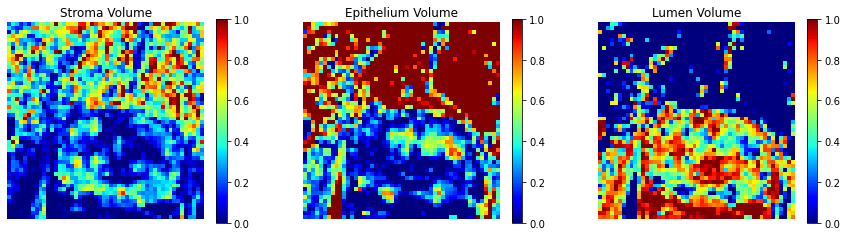

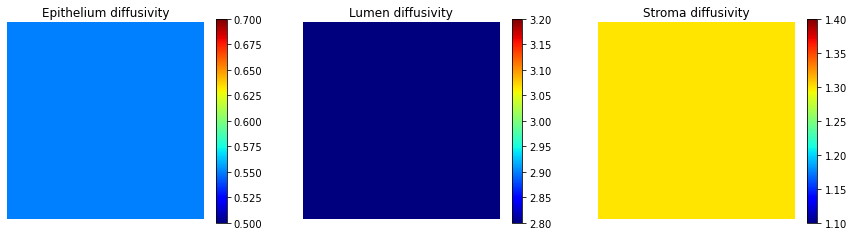

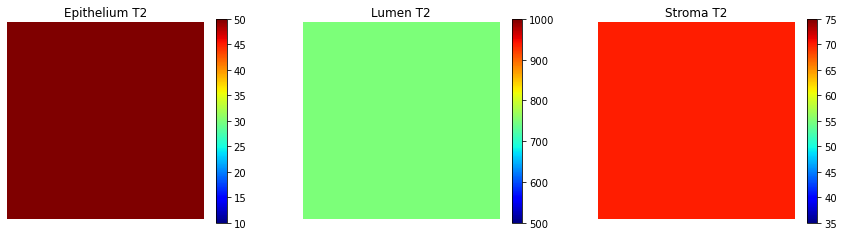

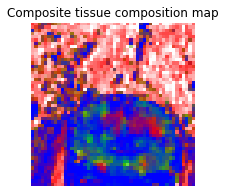

In [20]:

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
im = ax[0].imshow(out[:,:,7], vmin = 0, vmax = 1, cmap = 'jet')
ax[0].set_title('Stroma Volume')
fig.colorbar(im, ax=ax[0],shrink=0.75)
ax[0].axis('off') 

im = ax[1].imshow(out[:,:,6], vmin = 0, vmax = 1, cmap = 'jet')
ax[1].set_title('Epithelium Volume')
fig.colorbar(im, ax=ax[1],shrink=0.75)
ax[1].axis('off')

im = ax[2].imshow(out[:,:,8], vmin = 0, vmax = 1, cmap = 'jet')
ax[2].set_title('Lumen Volume')
fig.colorbar(im, ax=ax[2],shrink=0.75)
ax[2].axis('off')


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
im = ax[0].imshow(out[:,:,0], vmin = 0.5, vmax = 0.7, cmap = 'jet')
ax[0].set_title('Epithelium diffusivity')
fig.colorbar(im, ax=ax[0],shrink=0.75)
ax[0].axis('off')


im = ax[1].imshow(out[:,:,1], vmin = 2.8, vmax = 3.2, cmap = 'jet')
ax[1].set_title('Lumen diffusivity')
fig.colorbar(im, ax=ax[1],shrink=0.75)
ax[1].axis('off')

im = ax[2].imshow(out[:,:,2], vmin = 1.1, vmax = 1.4, cmap = 'jet')
ax[2].set_title('Stroma diffusivity')
fig.colorbar(im, ax=ax[2],shrink=0.75)
ax[2].axis('off')

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
im = ax[0].imshow(out[:,:,3], vmin = 10, vmax = 50, cmap = 'jet')
ax[0].set_title('Epithelium T2')
fig.colorbar(im, ax=ax[0],shrink=0.75)
ax[0].axis('off')


im = ax[1].imshow(out[:,:,4], vmin = 500, vmax = 1000, cmap = 'jet')
ax[1].set_title('Lumen T2')
fig.colorbar(im, ax=ax[1],shrink=0.75)
ax[1].axis('off')

im = ax[2].imshow(out[:,:,5], vmin = 35, vmax = 75, cmap = 'jet')
ax[2].set_title('Stroma T2')
fig.colorbar(im, ax=ax[2],shrink=0.75)
ax[2].axis('off')
rgbImage = np.dstack((abs(out[:,:,6]), abs(out[:,:,7]), abs(out[:,:,8])))
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(rgbImage)
ax.set_title('Composite tissue composition map')
ax.axis('off')

In [21]:
def adc_voxel(b, S):
    min_adc = 0
    max_adc = 3.0
    all_bs = [[[b[i], np.log(S[i] + eps)]] for i in range(len(b))]
    combs = [x for x in itertools.product(*all_bs)]
    def lms_adc(inpt):
        sum_xi_yi = sum([x[0]*x[1] for x in inpt])
        sum_yj = sum([x[1] for x in inpt])
        sum_xi_sum_yj = sum([x[0]*sum_yj for x in inpt])
        sum_x2 = sum([x[0]**2 for x in inpt])
        sum_x = sum([x[0] for x in inpt])
        adc = -(len(inpt)*sum_xi_yi - sum_xi_sum_yj)/(len(inpt)*sum_x2 - sum_x**2 )*1000
        return adc
    return max(min(lms_adc(combs[0]), max_adc), min_adc)

In [22]:
def ADC_slice(bvalues, slicedata):
    numrows, numcols, numbvalues = slicedata.shape
    #Set up a matrix for the four fit coefficients and the R^2
    adc_map = np.zeros((numrows, numcols))
    for row in range(numrows):
        for col in range(numcols):
            ydata = np.squeeze(slicedata[row,col,:])
            adc_map[row, col] = adc_voxel(bvalues, ydata)
    return adc_map

In [23]:
def T2_voxel(TE, S):
    min_T2 = 0
    max_T2 = 750
    eps = 1e-7
    all_bs = [[[TE[i], np.log(S[i] + eps)]] for i in range(len(TE))]
    combs = [x for x in itertools.product(*all_bs)]
    def lms_T2(inpt):
        sum_xi_yi = sum([x[0]*x[1] for x in inpt])
        sum_yj = sum([x[1] for x in inpt])
        sum_xi_sum_yj = sum([x[0]*sum_yj for x in inpt])
        sum_x2 = sum([x[0]**2 for x in inpt])
        sum_x = sum([x[0] for x in inpt])
        T2 = -(len(inpt)*sum_xi_yi - sum_xi_sum_yj)/(len(inpt)*sum_x2 - sum_x**2 )
        return T2
    return max(min(1/(lms_T2(combs[0]) + eps), max_T2), min_T2)

In [24]:
def T2_quantitative_slice(TE, slicedata):
    numrows, numcols, numbvalues = slicedata.shape
    T2_map = np.zeros((numrows, numcols))
    for row in range(numrows):
        for col in range(numcols):
            ydata = np.squeeze(slicedata[row,col,:])
            T2_map[row, col] = T2_voxel(TE, ydata)
    return T2_map

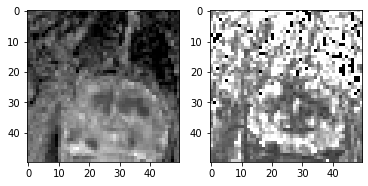

In [25]:
adc_map = ADC_slice(b, hybrid_crop[:,:, sliceIndex, :, 0])
fig, ax = plt.subplots(1,2)
ax[0].imshow(adc_map, cmap='gray')
T2_map = T2_quantitative_slice(TE, hybrid_crop[:,:, sliceIndex, 0, :])
ax[1].imshow(T2_map, cmap='gray', vmax=200)

In [26]:
TE

array([ 57.,  70., 150., 200.])

In [27]:
def CreateInputImageDict(inHybrid, inADCMap, inT2Map):
    """
 Given the parallel arrays of images generated by the hybrid (used to be called "out"),
 ADC, and T2, creates a single image map structure with the
 images that we're interested in processing, with the various images then
 accessible using key/value pairs:

    %   'ADC'
    %   'T2'
    %   'D_ep'
    %   'D_lu'
    %   'D_st'
    %   'T2_ep'
    %   'T2_lu'
    %   'T2_st'
    %   'V_ep'
    %   'V_lu'
    %   'V_st'
    %   'cancer'
    
    """
    imageMap = dict()
    
    imageMap['ADC'] = inADCMap
    imageMap['T2'] = inT2Map

    imageMap['D_ep'] = inHybrid[:,:,0]
    imageMap['D_lu'] = inHybrid[:,:,1]
    imageMap['D_st'] = inHybrid[:,:,2]
    
    imageMap['T2_ep'] = inHybrid[:,:,3]
    imageMap['T2_lu'] = inHybrid[:,:,4]
    imageMap['T2_st'] = inHybrid[:,:,5]

    imageMap['V_ep'] = inHybrid[:,:,6]
    imageMap['V_st'] = inHybrid[:,:,7] #Note the different order than with the first tuples
    imageMap['V_lu'] = inHybrid[:,:,8]
    

    
    imageMap['cancer'] =    (imageMap['V_ep'] > 0.4)*(imageMap['V_lu'] <= 0.2)
    
        
    return imageMap

In [28]:
hybrid_dict = CreateInputImageDict(out, adc_map, T2_map)

(-0.5, 49.5, 49.5, -0.5)

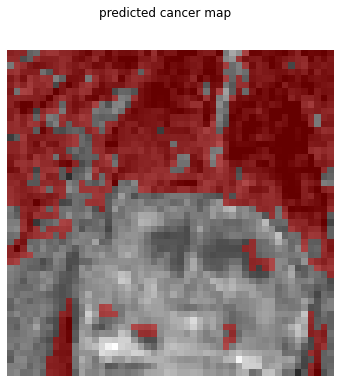

In [29]:
from skimage import morphology
from skimage import segmentation
b0_th = 0#5000
data_th = 3#1000
signal = np.squeeze(hybrid_crop[:,:, 8, 3, 0])
b0 = np.squeeze(hybrid_crop[:,:, 8, 0, 0])
mask = b0 > b0_th
mask2 = signal > data_th
data_segmented = mask2*signal
b0_segmented = mask*b0
#mask = mask*mask2
fig, ax = plt.subplots(1, figsize=(6,6))
fig.suptitle('predicted cancer map')
ax.imshow(adc_map, cmap='gray')
cancer_map = np.multiply(hybrid_dict['cancer'].astype(float), mask.astype(float))
cancer_map = np.multiply(cancer_map, mask2.astype(float))
cancer_map = morphology.remove_small_objects(cancer_map.astype(bool), min_size=5, connectivity=1)
cancer_map = cancer_map.astype(float)
cancer_map[cancer_map==0] = np.nan
ax.imshow(cancer_map, cmap='autumn',alpha = 0.4)
ax.axis('off')